http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [925]:
from tensorflow.contrib import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Masking

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import psycopg2
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

In [545]:
# fix random seed for reproducibility
np.random.seed(7)

# Load data

In [546]:
data = pd.read_csv('rnn_train/chenmark.csv')

# drop the first contest--too much variance
data.sort_values('ratingupdatetimeseconds', inplace=True)
firstcid = data.contestid.values[0]

#data.reset_index(inplace=True)
data.drop(data.index[data.contestid == firstcid], axis=0, inplace=True)

In [547]:
con = psycopg2.connect(database='codeforces', user='Joy')
cur = con.cursor()

## binarize some variables

In [548]:
cur.execute("select * from all_participanttypes", con)
all_part = [c[1] for c in cur.fetchall()]

cur.execute("select * from all_tags", con)
all_tags = [c[1] for c in cur.fetchall()]

cur.execute("select * from all_language", con)
all_lang = [c[1] for c in cur.fetchall()]

#cur.execute("select * from all_verdicts", con)
#all_verd = [c[1] for c in cur.fetchall()]

In [549]:
# set binary columns to binary, some of them were counts by mistake
bin_vars = all_part + all_tags + all_lang
data[bin_vars] = data[bin_vars].fillna(value=0)

for b in bin_vars:
    data.loc[ data[b] > 0, b] = 1

In [550]:
data.head()

,CHALLENGED,COMPILATION_ERROR,CONTESTANT,CRASHED,GNU C++,GNU C++11,GYM,MEMORY_LIMIT_EXCEEDED,MS C++,Mysterious Language,...,FALSE,Mono C#,Java 7,Tcl,Haskell,Cobol,Io,GNU C++0x,GNU C++14,GNU C++11 ZIP
142,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [551]:
for c in data.columns:
    print c

CHALLENGED
COMPILATION_ERROR
CONTESTANT
CRASHED
GNU C++
GNU C++11
GYM
MEMORY_LIMIT_EXCEEDED
MS C++
Mysterious Language
OK
OUT_OF_COMPETITION
PARTIAL
PRACTICE
PyPy 2
Python 2
REJECTED
RUNTIME_ERROR
SKIPPED
TIME_LIMIT_EXCEEDED
VIRTUAL
WRONG_ANSWER
contestid
delta_smoothed_1months
delta_smoothed_2months
delta_smoothed_3months
delta_smoothed_4months
delta_smoothed_5months
handle
index
newrating
oldrating
points
problem_rating
rank
ratingupdatetimeseconds
smoothed_1months
smoothed_2months
smoothed_3months
smoothed_4months
smoothed_5months
solvetimeseconds
starttimeseconds
stoptimeseconds
shortest paths
2-sat
greedy
meet-in-the-middle
matrices
number theory
constructive algorithms
chinese remainder theorem
implementation
ternary search
schedules
dsu
dfs and similar
graph matchings
string suffix structures
math
probabilities
fft
divide and conquer
two pointers
trees
data structures
flows
sortings
expression parsing
dp
hashing
bitmasks
*special
geometry
combinatorics
graphs
brute force
games
b

##  Remove unnecessary columns

In [552]:
month = 3

In [553]:
df_data = data
for m in range(1,6):
    if m == month:
        continue
    name1 = "delta_smoothed_%dmonths" % m
    name2 = "smoothed_%dmonths" % m
    
    df_data.drop([name1, name2], axis=1, inplace=True)

df_train = df_data.drop(['handle', 'index'], axis=1)

In [554]:
df_train.fillna(value=0, inplace=True)

## Feature scaling and grouping by contest

In [555]:
colname = 'delta_smoothed_%dmonths' % month
cols = list(df_train.columns.values)
colidx = cols.index(colname)

cids = df_train.contestid

scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled)
df_train_scaled.columns = cols

# add back in cols that should not be scaled
df_train_scaled['contestid'] = cids
df_train_scaled[colname] = df_train[colname]

In [556]:
groups = df_train_scaled.groupby('contestid')

In [557]:
trainlist = []
ylist = []
bins = range(-200, 200, 20)

for k, v in groups:
    base = [0] * (len(bins) + 1)
    v.is_copy = False
    
    v.drop('contestid', axis=1, inplace=True)
    y = v.loc[:, colname].values[0]
    v.drop(colname, inplace=True, axis=1)
    
    trainlist.append(v)
    ylist.append(y)

In [558]:
min(ylist), max(ylist)

(-23.699999999999999, 65.314285709999993)

In [584]:
yvecs = [ [0] * (len(bins) + 1) for i in range(len(ylist))]
idx1 = np.digitize(ylist, bins=bins)

for i, j in enumerate(idx1):
    yvecs[i][j] = 1
#yvecs

In [560]:
ary = np.array(yvecs)

In [561]:
len(trainlist), len(ylist)

(88, 88)

## Pad X values

In [562]:
# TODO: need to make this "universal" across all users
maxtimepts = max([len(t) for t in trainlist])
size = trainlist[0].shape[1]

for i in range(len(trainlist)):
    gap = maxtimepts - len(trainlist[i])
    for j in range(gap):
        nullrow = [0] * size
        trainlist[i].loc[-j-1] = nullrow
    trainlist[i].sort_index(inplace = True)

In [583]:
#print len(trainlist)
#[t.shape for t in trainlist]

In [564]:
dfx = pd.concat(trainlist)
dfx.reset_index(inplace=True, drop=True)

In [565]:
arx = np.array(dfx)
arx = np.reshape(arx, (len(trainlist), maxtimepts, 111))

# Set up keras model
https://keras.io/layers/recurrent/
https://keras.io/getting-started/sequential-model-guide/

```keras.layers.recurrent.Recurrent(return_sequences=False, go_backwards=False, stateful=False, unroll=False, implementation=0)```
* ```weights```: list of Numpy arrays to set as initial weights. The list should have 3 elements, of shapes: [(input_dim, output_dim), (output_dim, output_dim), (output_dim,)].
* ```return_sequences```: Boolean. Whether to return the last output in the output sequence, or the full sequence.
* ```go_backwards```: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
* ```stateful```: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
* ```unroll```: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.
* ```implementation```: one of {0, 1, or 2}. If set to 0, the RNN will use an implementation that uses fewer, larger matrix products, thus running faster on CPU but consuming more memory. If set to 1, the RNN will use more matrix products, but smaller ones, thus running slower (may actually be faster on GPU) while consuming less memory. If set to 2 (LSTM/GRU only), the RNN will combine the input gate, the forget gate and the output gate into a single matrix, enabling more time-efficient parallelization on the GPU.
    * Note: RNN dropout must be shared for all gates, resulting in a slightly reduced regularization.
* ```input_dim```: dimensionality of the input (integer). This argument (or alternatively, the keyword argument input_shape) is required when using this layer as the first layer in a model.
* ```input_length```: Length of input sequences, to be specified when it is constant. This argument is required if you are going to connect  Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed). Note that if the recurrent layer is not the first layer in your model, you would need to specify the input length at the level of the first layer (e.g. via the input_shape argument)

**Note on using statefulness in RNNs**

You can set RNN layers to be 'stateful', which means that the states computed for the samples in one batch will be reused as initial states for the samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches.

To enable statefulness:
- specify ```stateful=True``` in the layer constructor. 
- specify a fixed batch size for your model, by passing if sequential model:  ```batch_input_shape=(...)``` to the first layer in your model.
else for functional model with 1 or more Input layers:  ```batch_shape=(...)``` to all the first layers in your model.
This is the expected shape of your inputs including the batch size. It should be a tuple of integers, e.g. (32, 10, 100).
- specify ```shuffle=False``` when calling ```fit()```.

To reset the states of your model, call ```.reset_states()``` on either a specific layer, or on your entire model.

# NOTE CURRENTLY USING THE WRONG OUTPUT LAYER, NEED REGRESSION NOT CLASSIFICATION

In [566]:
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU

In [782]:
cur.execute("select * from all_participanttypes", con)
all_part = [c[1] for c in cur.fetchall()]

cur.execute("select * from all_tags", con)
all_tags = [c[1] for c in cur.fetchall()]

cur.execute("select * from all_language", con)
all_lang = [c[1] for c in cur.fetchall()]

In [783]:
def get_user_data(user):
    # set some parameters for normalization
    max_change = 200.0
    
    # -----------------------------
    # Load data
    data = pd.read_csv('rnn_train/%s.csv'%user)

    # drop the first contest--we don't have a "real" change from a null expectation here
    data.sort_values('ratingupdatetimeseconds', inplace=True)
    firstcid = data.contestid.values[0]
    data.drop(data.index[data.contestid == firstcid], axis=0, inplace=True)

    # -----------------------------
    # binarize some variables
    # set binary columns to binary, some of them were counts by mistake
    bin_vars = all_part + all_tags + all_lang
    data[bin_vars] = data[bin_vars].fillna(value=0)

    for b in bin_vars:
        data.loc[ data[b] > 0, b] = 1

    # -----------------------------
    # remove information for other months
    df_data = data
    for m in range(1,6):
        if m == month:
            continue
        name1 = "delta_smoothed_%dmonths" % m
        name2 = "smoothed_%dmonths" % m
        
        df_data.drop([name1, name2], axis=1, inplace=True)

    df_train = df_data.drop(['handle', 'index'], axis=1)
    df_train.fillna(value=0, inplace=True)


    # -----------------------------
    # Feature scaling
    colname = 'delta_smoothed_%dmonths' % month
    cols = list(df_train.columns.values)
    colidx = cols.index(colname)

    cids = df_train.contestid

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled = scaler.fit_transform(df_train)
    df_train_scaled = pd.DataFrame(df_train_scaled)
    df_train_scaled.columns = cols

    # add back in cols that should not be scaled
    df_train_scaled['contestid'] = cids
    df_train_scaled[colname] = df_train[colname]
    
    # scale the y column wrt to max change possible
    df_train_scaled[colname] /= max_change

    # -----------------------------
    # Group by contest
    groups = df_train_scaled.groupby('contestid')

    # -----------------------------
    # create list of inputs for training
    trainlist = []
    ylist = []

    for k, v in groups:
        base = [0] * (len(bins) + 1)
        v.is_copy = False
        
        v.drop('contestid', axis=1, inplace=True)
        y = v.loc[:, colname].values[0]
        v.drop(colname, inplace=True, axis=1)
        
        trainlist.append(v)
        ylist.append(y)

    ary = np.array(ylist)

    # -----------------------------
    # Pad X values
    # TODO: need to make this "universal" across all users
    #maxtimepts = max([len(t) for t in trainlist])
    size = trainlist[0].shape[1]

    for i in range(len(trainlist)):
        gap = maxtimepts - len(trainlist[i])
        for j in range(gap):
            nullrow = [0] * size
            trainlist[i].loc[-j-1] = nullrow
        trainlist[i].sort_index(inplace = True)


    dfx = pd.concat(trainlist)
    dfx.reset_index(inplace=True, drop=True)

    arx = np.array(dfx)
    arx = np.reshape(arx, (len(trainlist), maxtimepts, 111))
    return arx, ary



In [ ]:
xx_train, yy_train = get_user_data("lewin")

In [912]:
xx_test, yy_test = get_user_data("yj12")

In [970]:
xx_test2, yy_test2 = get_user_data("chenmark")

In [785]:
maxtimepts = 110 #max([len(t) for t in trainlist])
size = 111 #trainlist[0].shape[1]

110 111 20


In [986]:
def create_model(layer1, layer2, batch_input_shape):
    model = Sequential()
    model.add(Masking(mask_value=0, batch_input_shape = batch_input_shape))
    model.add(GRU(layer1, return_sequences=True, stateful=True, batch_input_shape=batch_input_shape))
    model.add(Dropout(0.5))
    model.add(GRU(layer2, return_sequences=False, stateful=True, batch_input_shape=batch_input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.5))
    # we use a linear activation for the output
    model.add(Dense(1, activation='tanh'))
    return model

In [987]:
neurons1 = 10
neurons2 = 4
model = create_model(neurons1, neurons2, xx_train.shape)

In [988]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_9 (Masking)          (49, 110, 111)            0         
_________________________________________________________________
gru_82 (GRU)                 (49, 110, 10)             3660      
_________________________________________________________________
dropout_115 (Dropout)        (49, 110, 10)             0         
_________________________________________________________________
gru_83 (GRU)                 (49, 4)                   180       
_________________________________________________________________
dropout_116 (Dropout)        (49, 4)                   0         
_________________________________________________________________
dense_87 (Dense)             (49, 50)                  250       
_________________________________________________________________
dropout_117 (Dropout)        (49, 50)                  0         
__________

In [989]:
optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])
#model.reset_states()

In [990]:
print batch_input_shape
print model.output_shape

print xx_train.shape
print yy_train.shape

(88, 110, 111)
(49, 1)
(49, 110, 111)
(49,)


In [991]:
history = model.fit(xx_train, yy_train, epochs=500, batch_size=xx_train.shape[0], shuffle=False)

Epoch 1/500
49/49 [==============================] - 5s - loss: 0.1361 - mean_absolute_error: 0.2763
Epoch 2/500
49/49 [==============================] - 0s - loss: 0.1389 - mean_absolute_error: 0.3103
Epoch 3/500
49/49 [==============================] - 0s - loss: 0.2288 - mean_absolute_error: 0.3896
Epoch 4/500
49/49 [==============================] - 0s - loss: 0.1611 - mean_absolute_error: 0.3210
Epoch 5/500
49/49 [==============================] - 0s - loss: 0.1688 - mean_absolute_error: 0.3074
Epoch 6/500
49/49 [==============================] - 0s - loss: 0.1167 - mean_absolute_error: 0.2783
Epoch 7/500
49/49 [==============================] - 0s - loss: 0.0997 - mean_absolute_error: 0.2453
Epoch 8/500
49/49 [==============================] - 0s - loss: 0.1144 - mean_absolute_error: 0.2633
Epoch 9/500
49/49 [==============================] - 0s - loss: 0.0647 - mean_absolute_error: 0.1842
Epoch 10/500
49/49 [==============================] - 0s - loss: 0.0811 - mean_absolute_err

49/49 [==============================] - 0s - loss: 0.0395 - mean_absolute_error: 0.1327
Epoch 82/500
49/49 [==============================] - 0s - loss: 0.0293 - mean_absolute_error: 0.1324
Epoch 83/500
49/49 [==============================] - 0s - loss: 0.0359 - mean_absolute_error: 0.1282
Epoch 84/500
49/49 [==============================] - 0s - loss: 0.0408 - mean_absolute_error: 0.1648
Epoch 85/500
49/49 [==============================] - 0s - loss: 0.0525 - mean_absolute_error: 0.1710
Epoch 86/500
49/49 [==============================] - 0s - loss: 0.0455 - mean_absolute_error: 0.1598
Epoch 87/500
49/49 [==============================] - 0s - loss: 0.0275 - mean_absolute_error: 0.1162
Epoch 88/500
49/49 [==============================] - 0s - loss: 0.0379 - mean_absolute_error: 0.1394
Epoch 89/500
49/49 [==============================] - 0s - loss: 0.0377 - mean_absolute_error: 0.1317
Epoch 90/500
49/49 [==============================] - 0s - loss: 0.0346 - mean_absolute_error: 

49/49 [==============================] - 0s - loss: 0.0167 - mean_absolute_error: 0.1062
Epoch 161/500
49/49 [==============================] - 0s - loss: 0.0157 - mean_absolute_error: 0.0948
Epoch 162/500
49/49 [==============================] - 0s - loss: 0.0399 - mean_absolute_error: 0.1517
Epoch 163/500
49/49 [==============================] - 0s - loss: 0.0222 - mean_absolute_error: 0.1114
Epoch 164/500
49/49 [==============================] - 0s - loss: 0.0208 - mean_absolute_error: 0.1087
Epoch 165/500
49/49 [==============================] - 0s - loss: 0.0268 - mean_absolute_error: 0.1171
Epoch 166/500
49/49 [==============================] - 0s - loss: 0.0293 - mean_absolute_error: 0.1239
Epoch 167/500
49/49 [==============================] - 0s - loss: 0.0206 - mean_absolute_error: 0.1065
Epoch 168/500
49/49 [==============================] - 0s - loss: 0.0232 - mean_absolute_error: 0.1156
Epoch 169/500
49/49 [==============================] - 0s - loss: 0.0155 - mean_absolut

49/49 [==============================] - 0s - loss: 0.0191 - mean_absolute_error: 0.1074
Epoch 240/500
49/49 [==============================] - 0s - loss: 0.0336 - mean_absolute_error: 0.1471
Epoch 241/500
49/49 [==============================] - 0s - loss: 0.0241 - mean_absolute_error: 0.1164
Epoch 242/500
49/49 [==============================] - 0s - loss: 0.0117 - mean_absolute_error: 0.0849
Epoch 243/500
49/49 [==============================] - 0s - loss: 0.0157 - mean_absolute_error: 0.0909
Epoch 244/500
49/49 [==============================] - 0s - loss: 0.0110 - mean_absolute_error: 0.0781
Epoch 245/500
49/49 [==============================] - 0s - loss: 0.0165 - mean_absolute_error: 0.0933
Epoch 246/500
49/49 [==============================] - 0s - loss: 0.0134 - mean_absolute_error: 0.0878
Epoch 247/500
49/49 [==============================] - 0s - loss: 0.0181 - mean_absolute_error: 0.1010
Epoch 248/500
49/49 [==============================] - 0s - loss: 0.0185 - mean_absolut

49/49 [==============================] - 0s - loss: 0.0105 - mean_absolute_error: 0.0746
Epoch 319/500
49/49 [==============================] - 0s - loss: 0.0136 - mean_absolute_error: 0.0869
Epoch 320/500
49/49 [==============================] - 0s - loss: 0.0152 - mean_absolute_error: 0.0912
Epoch 321/500
49/49 [==============================] - 0s - loss: 0.0161 - mean_absolute_error: 0.0841
Epoch 322/500
49/49 [==============================] - 0s - loss: 0.0211 - mean_absolute_error: 0.1108
Epoch 323/500
49/49 [==============================] - 0s - loss: 0.0153 - mean_absolute_error: 0.0975
Epoch 324/500
49/49 [==============================] - 0s - loss: 0.0127 - mean_absolute_error: 0.0884
Epoch 325/500
49/49 [==============================] - 0s - loss: 0.0140 - mean_absolute_error: 0.0902
Epoch 326/500
49/49 [==============================] - 0s - loss: 0.0078 - mean_absolute_error: 0.0607
Epoch 327/500
49/49 [==============================] - 0s - loss: 0.0241 - mean_absolut

49/49 [==============================] - 0s - loss: 0.0094 - mean_absolute_error: 0.0697
Epoch 398/500
49/49 [==============================] - 0s - loss: 0.0088 - mean_absolute_error: 0.0715
Epoch 399/500
49/49 [==============================] - 0s - loss: 0.0253 - mean_absolute_error: 0.0995
Epoch 400/500
49/49 [==============================] - 0s - loss: 0.0090 - mean_absolute_error: 0.0711
Epoch 401/500
49/49 [==============================] - 0s - loss: 0.0177 - mean_absolute_error: 0.1023
Epoch 402/500
49/49 [==============================] - 0s - loss: 0.0108 - mean_absolute_error: 0.0821
Epoch 403/500
49/49 [==============================] - 0s - loss: 0.0199 - mean_absolute_error: 0.1074
Epoch 404/500
49/49 [==============================] - 0s - loss: 0.0181 - mean_absolute_error: 0.1012
Epoch 405/500
49/49 [==============================] - 0s - loss: 0.0300 - mean_absolute_error: 0.1256
Epoch 406/500
49/49 [==============================] - 0s - loss: 0.0096 - mean_absolut

49/49 [==============================] - 0s - loss: 0.0147 - mean_absolute_error: 0.0814
Epoch 477/500
49/49 [==============================] - 0s - loss: 0.0192 - mean_absolute_error: 0.0869
Epoch 478/500
49/49 [==============================] - 0s - loss: 0.0173 - mean_absolute_error: 0.0986
Epoch 479/500
49/49 [==============================] - 0s - loss: 0.0148 - mean_absolute_error: 0.0985
Epoch 480/500
49/49 [==============================] - 0s - loss: 0.0286 - mean_absolute_error: 0.1019
Epoch 481/500
49/49 [==============================] - 0s - loss: 0.0094 - mean_absolute_error: 0.0689
Epoch 482/500
49/49 [==============================] - 0s - loss: 0.0129 - mean_absolute_error: 0.0847
Epoch 483/500
49/49 [==============================] - 0s - loss: 0.0106 - mean_absolute_error: 0.0762
Epoch 484/500
49/49 [==============================] - 0s - loss: 0.0249 - mean_absolute_error: 0.0947
Epoch 485/500
49/49 [==============================] - 0s - loss: 0.0145 - mean_absolut

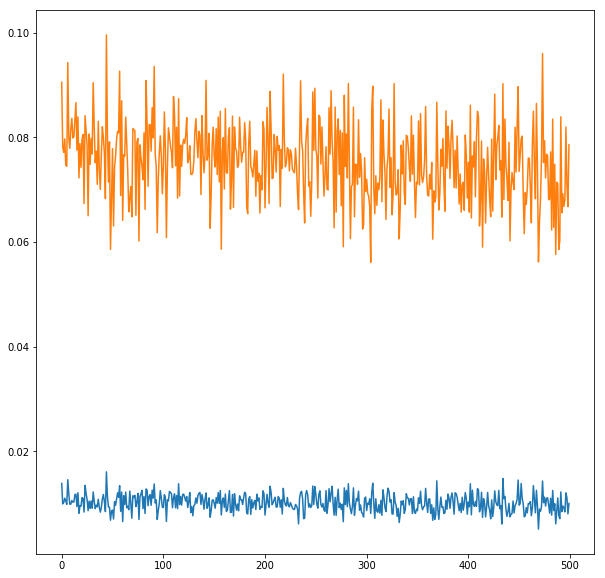

In [966]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])

In [965]:
history = newmodel.fit(xx_test, yy_test, epochs=500, batch_size=xx_test.shape[0], shuffle=False)

Epoch 1/500
17/17 [==============================] - 0s - loss: 0.0138 - mean_absolute_error: 0.0905
Epoch 2/500
17/17 [==============================] - 0s - loss: 0.0099 - mean_absolute_error: 0.0781
Epoch 3/500
17/17 [==============================] - 0s - loss: 0.0102 - mean_absolute_error: 0.0771
Epoch 4/500
17/17 [==============================] - 0s - loss: 0.0110 - mean_absolute_error: 0.0797
Epoch 5/500
17/17 [==============================] - 0s - loss: 0.0105 - mean_absolute_error: 0.0747
Epoch 6/500
17/17 [==============================] - 0s - loss: 0.0098 - mean_absolute_error: 0.0745
Epoch 7/500
17/17 [==============================] - 0s - loss: 0.0146 - mean_absolute_error: 0.0943
Epoch 8/500
17/17 [==============================] - 0s - loss: 0.0117 - mean_absolute_error: 0.0799
Epoch 9/500
17/17 [==============================] - 0s - loss: 0.0099 - mean_absolute_error: 0.0779
Epoch 10/500
17/17 [==============================] - 0s - loss: 0.0099 - mean_absolute_err

17/17 [==============================] - 0s - loss: 0.0090 - mean_absolute_error: 0.0719
Epoch 82/500
17/17 [==============================] - 0s - loss: 0.0113 - mean_absolute_error: 0.0809
Epoch 83/500
17/17 [==============================] - 0s - loss: 0.0081 - mean_absolute_error: 0.0662
Epoch 84/500
17/17 [==============================] - 0s - loss: 0.0128 - mean_absolute_error: 0.0909
Epoch 85/500
17/17 [==============================] - 0s - loss: 0.0126 - mean_absolute_error: 0.0825
Epoch 86/500
17/17 [==============================] - 0s - loss: 0.0096 - mean_absolute_error: 0.0707
Epoch 87/500
17/17 [==============================] - 0s - loss: 0.0113 - mean_absolute_error: 0.0825
Epoch 88/500
17/17 [==============================] - 0s - loss: 0.0117 - mean_absolute_error: 0.0824
Epoch 89/500
17/17 [==============================] - 0s - loss: 0.0097 - mean_absolute_error: 0.0774
Epoch 90/500
17/17 [==============================] - 0s - loss: 0.0125 - mean_absolute_error: 

17/17 [==============================] - 0s - loss: 0.0111 - mean_absolute_error: 0.0799
Epoch 161/500
17/17 [==============================] - 0s - loss: 0.0092 - mean_absolute_error: 0.0701
Epoch 162/500
17/17 [==============================] - 0s - loss: 0.0118 - mean_absolute_error: 0.0855
Epoch 163/500
17/17 [==============================] - 0s - loss: 0.0085 - mean_absolute_error: 0.0733
Epoch 164/500
17/17 [==============================] - 0s - loss: 0.0088 - mean_absolute_error: 0.0731
Epoch 165/500
17/17 [==============================] - 0s - loss: 0.0106 - mean_absolute_error: 0.0801
Epoch 166/500
17/17 [==============================] - 0s - loss: 0.0125 - mean_absolute_error: 0.0818
Epoch 167/500
17/17 [==============================] - 0s - loss: 0.0083 - mean_absolute_error: 0.0663
Epoch 168/500
17/17 [==============================] - 0s - loss: 0.0083 - mean_absolute_error: 0.0717
Epoch 169/500
17/17 [==============================] - 0s - loss: 0.0117 - mean_absolut

17/17 [==============================] - 0s - loss: 0.0071 - mean_absolute_error: 0.0694
Epoch 240/500
17/17 [==============================] - 0s - loss: 0.0072 - mean_absolute_error: 0.0636
Epoch 241/500
17/17 [==============================] - 0s - loss: 0.0117 - mean_absolute_error: 0.0783
Epoch 242/500
17/17 [==============================] - 0s - loss: 0.0125 - mean_absolute_error: 0.0816
Epoch 243/500
17/17 [==============================] - 0s - loss: 0.0116 - mean_absolute_error: 0.0836
Epoch 244/500
17/17 [==============================] - 0s - loss: 0.0093 - mean_absolute_error: 0.0707
Epoch 245/500
17/17 [==============================] - 0s - loss: 0.0099 - mean_absolute_error: 0.0715
Epoch 246/500
17/17 [==============================] - 0s - loss: 0.0092 - mean_absolute_error: 0.0649
Epoch 247/500
17/17 [==============================] - 0s - loss: 0.0096 - mean_absolute_error: 0.0715
Epoch 248/500
17/17 [==============================] - 0s - loss: 0.0133 - mean_absolut

17/17 [==============================] - 0s - loss: 0.0112 - mean_absolute_error: 0.0768
Epoch 319/500
17/17 [==============================] - 0s - loss: 0.0092 - mean_absolute_error: 0.0733
Epoch 320/500
17/17 [==============================] - 0s - loss: 0.0085 - mean_absolute_error: 0.0643
Epoch 321/500
17/17 [==============================] - 0s - loss: 0.0114 - mean_absolute_error: 0.0742
Epoch 322/500
17/17 [==============================] - 0s - loss: 0.0129 - mean_absolute_error: 0.0764
Epoch 323/500
17/17 [==============================] - 0s - loss: 0.0123 - mean_absolute_error: 0.0854
Epoch 324/500
17/17 [==============================] - 0s - loss: 0.0103 - mean_absolute_error: 0.0705
Epoch 325/500
17/17 [==============================] - 0s - loss: 0.0107 - mean_absolute_error: 0.0761
Epoch 326/500
17/17 [==============================] - 0s - loss: 0.0080 - mean_absolute_error: 0.0652
Epoch 327/500
17/17 [==============================] - 0s - loss: 0.0080 - mean_absolut

17/17 [==============================] - 0s - loss: 0.0099 - mean_absolute_error: 0.0661
Epoch 398/500
17/17 [==============================] - 0s - loss: 0.0121 - mean_absolute_error: 0.0804
Epoch 399/500
17/17 [==============================] - 0s - loss: 0.0110 - mean_absolute_error: 0.0767
Epoch 400/500
17/17 [==============================] - 0s - loss: 0.0080 - mean_absolute_error: 0.0684
Epoch 401/500
17/17 [==============================] - 0s - loss: 0.0103 - mean_absolute_error: 0.0752
Epoch 402/500
17/17 [==============================] - 0s - loss: 0.0094 - mean_absolute_error: 0.0657
Epoch 403/500
17/17 [==============================] - 0s - loss: 0.0138 - mean_absolute_error: 0.0861
Epoch 404/500
17/17 [==============================] - 0s - loss: 0.0078 - mean_absolute_error: 0.0646
Epoch 405/500
17/17 [==============================] - 0s - loss: 0.0125 - mean_absolute_error: 0.0765
Epoch 406/500
17/17 [==============================] - 0s - loss: 0.0098 - mean_absolut

17/17 [==============================] - 0s - loss: 0.0112 - mean_absolute_error: 0.0794
Epoch 477/500
17/17 [==============================] - 0s - loss: 0.0095 - mean_absolute_error: 0.0722
Epoch 478/500
17/17 [==============================] - 0s - loss: 0.0110 - mean_absolute_error: 0.0768
Epoch 479/500
17/17 [==============================] - 0s - loss: 0.0111 - mean_absolute_error: 0.0764
Epoch 480/500
17/17 [==============================] - 0s - loss: 0.0098 - mean_absolute_error: 0.0681
Epoch 481/500
17/17 [==============================] - 0s - loss: 0.0082 - mean_absolute_error: 0.0682
Epoch 482/500
17/17 [==============================] - 0s - loss: 0.0110 - mean_absolute_error: 0.0772
Epoch 483/500
17/17 [==============================] - 0s - loss: 0.0078 - mean_absolute_error: 0.0623
Epoch 484/500
17/17 [==============================] - 0s - loss: 0.0125 - mean_absolute_error: 0.0835
Epoch 485/500
17/17 [==============================] - 0s - loss: 0.0086 - mean_absolut

## test data

In [971]:
newmodel = create_model(neurons1, neurons2, xx_test2.shape)
old_weights = model.get_weights()
newmodel.set_weights(old_weights)

newmodel.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mae'])

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [972]:
score = newmodel.evaluate(xx_test2, yy_test2, batch_size=xx_test2.shape[0])

print newmodel.metrics_names
score

88/88 [==============================] - 3s
['loss', 'mean_absolute_error']


[0.045973852276802063, 0.14971128106117249]

In [978]:
y_pred_train = model.predict(xx_train, batch_size=xx_train.shape[0])
y_pred_test = newmodel.predict(xx_test2, batch_size=xx_test2.shape[0])

In [977]:
from sklearn.metrics import r2_score
print r2_score(yy_train, y_pred_train)
print r2_score(yy_test2, y_pred_test)

0.712424047663
-10.7343364026


Looks like we overfit the crap out of that one. Let's look at the number of parameters in this system

In [870]:
#model.reset_states()
#newmodel.reset_states()